<a href="https://colab.research.google.com/github/MoBanerjee/SC4001_Project/blob/main/VGG16_MSResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective of Notebook
### The objective of this notebook is to fine-tune a pre-trained VGG16 model with multi-scale convolutions and Squeeze-and-Excitation blocks on the Flowers102 dataset, implementing early stopping based on validation accuracy. It is later evaluated on test dataset

In [15]:
#necessary imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

In [16]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), #resize the image to 224x224
    transforms.ToTensor(), #convert it to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #normalize using ImageNet mean and std
])

In [17]:
# loading the Flowers102 dataset for training, validation, and testing, applying the defined transformations and downloading
train_data = torchvision.datasets.Flowers102(root='./data', split='train', transform=transform, download=True)
val_data = torchvision.datasets.Flowers102(root='./data', split='val', transform=transform, download=True)
test_data = torchvision.datasets.Flowers102(root='./data', split='test', transform=transform, download=True)

In [18]:
# creating data loaders for training, validation, and testing with a batch size of 32, shuffling only the training data.
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

### We are implementing a custom neural network architecture based on the VGG16 model with several innovations. Specifically, we are integrating a Squeeze-and-Excitation (SE) block into the residual network structure for improved channel-wise attention. The architecture includes a ResidualBlockWithMultiScaleConv that combines multiple convolutional branches (1x1, 3x3, 5x5) to capture different receptive fields. This is followed by a VGG16Innovative model that modifies the original VGG16 feature extractor by adding the multi-scale residual block, enhancing the network's ability to learn richer features. Additionally, we modify the classifier to improve generalization, using batch normalization and dropout layers. This custom model is tailored to work on the Flowers102 dataset for image classification.

In [19]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        # initialize the SEBlock (Squeeze-and-Excitation Block)
        # in_channels: number of input channels for the block
        # reduction: factor by which to reduce channels in the squeeze operation
        super(SEBlock, self).__init__()

        # first fully connected (FC) layer to reduce channels by the reduction factor
        # the output of this layer will have in_channels / reduction features
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)

        # second fully connected (FC) layer to restore channels back to the original count
        # this maps the reduced features back to in_channels
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)

    def forward(self, x):
        # x: input tensor with shape [batch_size, num_channels, height, width]

        # get batch size and number of channels
        batch_size, num_channels, _, _ = x.size()

        # squeeze operation: Global average pooling across spatial dimensions (height and width)
        # this produces a tensor of shape [batch_size, num_channels], effectively summarizing each channel
        squeeze = x.view(batch_size, num_channels, -1).mean(dim=2)

        # first FC layer (reduction phase): Reduce the number of channels by the reduction factor
        # pass the squeezed output through the FC layer
        excitation = self.fc1(squeeze)

        # apply ReLU activation for non-linearity after the first FC layer
        excitation = nn.ReLU(inplace=True)(excitation)

        # second FC layer (expansion phase): Restore the number of channels back to in_channels
        excitation = self.fc2(excitation)

        # apply sigmoid activation to normalize the channel weights to the range [0, 1]
        # this creates a channel-wise gating mechanism
        excitation = nn.Sigmoid()(excitation).view(batch_size, num_channels, 1, 1)

        # scale the original input tensor by the learned channel weights
        # multiply the input x with the excitation weights (broadcasting across height and width)
        return x * excitation


In [20]:
class ResidualBlockWithMultiScaleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        # initialize the ResidualBlockWithMultiScaleConv, inheriting from nn.Module
        # in_channels: number of input channels
        # out_channels: number of output channels for each convolution branch
        super(ResidualBlockWithMultiScaleConv, self).__init__()

        # define a 1x1 convolution branch (branch1)
        # this performs a pointwise convolution, useful for channel reduction or expansion
        # no padding is needed for a 1x1 convolution
        self.branch1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, bias=False)

        # define a 3x3 convolution branch (branch2)
        # this performs a standard convolution with a kernel size of 3, providing local context
        # padding of 1 ensures the output has the same spatial dimensions as the input
        self.branch2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)

        # define a 5x5 convolution branch (branch3)
        # this performs a larger convolution with a kernel size of 5, capturing a broader context
        # padding of 2 ensures the output has the same spatial dimensions as the input
        self.branch3 = nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2, bias=False)

        # batch normalization layer to normalize the output from the multi-scale branches
        # normalization improves training stability and accelerates convergence
        self.bn = nn.BatchNorm2d(out_channels)

        # define a SE Block to enhance the representational power of the block
        # this module learns channel-wise weights to selectively emphasize or suppress channels
        self.se = SEBlock(out_channels)

        # define a 1x1 convolution for the residual path to match the output dimensions if needed
        # if the number of input channels (in_channels) is not equal to the output channels (out_channels),
        # this 1x1 convolution adjusts the dimensions of the residual to match the output
        # if in_channels equals out_channels, residual_conv is set to None, and no adjustment is needed
        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, bias=False) if in_channels != out_channels else None

    def forward(self, x):
        # x: input tensor with shape [batch_size, in_channels, height, width]

        residual = x  # store the input as the residual connection
        if self.residual_conv:
            # if the residual_conv exists (when in_channels != out_channels), apply it to adjust the residual dimensions
            residual = self.residual_conv(x)

        # apply the three convolution branches (1x1, 3x3, and 5x5) in parallel to the input
        # each branch operates on the input independently and captures different receptive fields
        out = self.branch1(x) + self.branch2(x) + self.branch3(x)

        # normalize the combined output from the branches using batch normalization
        out = self.bn(out)

        # apply ReLU activation for non-linearity
        out = nn.ReLU(inplace=True)(out)

        # pass the output through the SE block for channel-wise recalibration
        # the SE block learns to emphasize or suppress channels based on global context
        out = self.se(out)

        # add the (possibly transformed) residual connection to the output of the block
        # this residual addition helps in training deeper networks by preserving information
        return out + residual


In [21]:
class VGG16Innovative(nn.Module):
    def __init__(self, original_model):
        # initialize the VGG16Innovative model, inheriting from nn.Module
        # original_model: the pre-trained VGG16 model to use as a base
        super(VGG16Innovative, self).__init__()

        # define the modified feature extractor
        # original_model.features[:24]: extracts the first 24 layers of the original VGG16 feature extractor
        # residualBlockWithMultiScaleConv(512, 512): adds a custom residual block with multi-scale convolutions
        # original_model.features[24:]: includes the remaining layers of the VGG16 feature extractor
        # this setup retains the majority of VGG16's architecture while adding an innovative block
        self.features = nn.Sequential(
            original_model.features[:24],  # first part of VGG16's feature extractor
            ResidualBlockWithMultiScaleConv(512, 512),  # add a custom residual block for enhanced feature extraction
            original_model.features[24:],  # remaining part of VGG16's feature extractor
        )

        # define the modified classifier with BatchNorm and Dropout layers for improved generalization
        # replaces the original VGG16 classifier with our new one to adapt to the new task
        # 25088 is the flattened size of the feature map after the convolutional layers for input size 224x224
        # 4096 is the number of neurons in each fully connected layer, and 102 represents the output classes for Flowers102 dataset
        self.classifier = nn.Sequential(
            nn.Linear(25088, 4096),  # first fully connected layer
            nn.ReLU(inplace=True),  # apply ReLU activation
            nn.BatchNorm1d(4096),  # apply batch normalization
            nn.Dropout(0.5),  # apply dropout with a 50% dropout rate for regularization
            nn.Linear(4096, 4096),  # second fully connected layer
            nn.ReLU(inplace=True),  # apply ReLU activation
            nn.BatchNorm1d(4096),  # apply batch normalization
            nn.Dropout(0.5),  # apply dropout for regularization
            nn.Linear(4096, 102),  # output layer with 102 classes for classification
        )

    def forward(self, x):
        # define the forward pass for the model
        # x: input tensor, representing a batch of images

        # pass the input through the modified feature extractor
        # the output shape will be [batch_size, 512, 7, 7] after the final convolutional layer in VGG16 for 224x224 input
        x = self.features(x)

        # flatten the output from the feature extractor to feed into the classifier
        # view(x.size(0), -1) reshapes the tensor to [batch_size, 25088] (7*7*512) for fully connected layers
        x = x.view(x.size(0), -1)

        # pass the flattened tensor through the modified classifier
        # this produces a tensor of shape [batch_size, 102], where 102 is the number of classes
        x = self.classifier(x)

        return x  # return the final logits for each class


In [22]:
# load the pre-trained VGG16 model from torchvision
model = torchvision.models.vgg16(pretrained=True)
# replace the original VGG16 model with our innovative version
model = VGG16Innovative(model)

In [23]:
# setting the device to GPU if available; otherwise, default to CPU, and then transfer the model to the selected device for optimized processing.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [24]:
# defining the loss function as cross-entropy for multi-class classification and setting up the Adam optimizer,
# applying it only to trainable parameters in the model with a learning rate of 0.001.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

In [25]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()  # set model to training mode
    running_loss = 0.0  # track cumulative loss
    correct = 0  # count correct predictions
    total = 0  # count total samples

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)  # move data to device
        optimizer.zero_grad()  # reset gradients
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # calculate loss
        loss.backward()  # backpropagate
        optimizer.step()  # update weights

        running_loss += loss.item()  # accumulate loss
        _, predicted = torch.max(outputs, 1)  # get predictions
        total += labels.size(0)  # update total samples
        correct += (predicted == labels).sum().item()  # update correct predictions

    return running_loss / len(dataloader), correct / total  # return average loss and accuracy

In [26]:
def validate_model(model, dataloader, criterion, device):
    model.eval()  # set model to evaluation mode
    running_loss = 0.0  # track cumulative loss
    correct = 0  # count correct predictions
    total = 0  # count total samples

    with torch.no_grad():  # disable gradient calculation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # move data to device
            outputs = model(inputs)  # forward pass
            loss = criterion(outputs, labels)  # calculate loss

            running_loss += loss.item()  # accumulate loss
            _, predicted = torch.max(outputs, 1)  # get predictions
            total += labels.size(0)  # update total samples
            correct += (predicted == labels).sum().item()  # update correct predictions

    return running_loss / len(dataloader), correct / total  # return average loss and accuracy

In [27]:
def test_model(model, dataloader, device):
    model.eval()  # set model to evaluation mode
    correct = 0  # count correct predictions
    total = 0  # count total samples

    with torch.no_grad():  # disable gradient calculation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # move data to device
            outputs = model(inputs)  # forward pass
            _, predicted = torch.max(outputs, 1)  # get predictions
            total += labels.size(0)  # update total samples
            correct += (predicted == labels).sum().item()  # update correct predictions

    return correct / total  # return accuracy as ratio of correct to total predictions

In [28]:
num_epochs = 100  # set the number of epochs for training
best_val_acc = 0.0  # initialize the best validation accuracy
patience = 5  # set patience for early stopping
counter = 0  # counter to track epochs without improvement
train_loss_history = []  # list to store training loss history
train_acc_history = []  # list to store training accuracy history
val_loss_history = []  # list to store validation loss history
val_acc_history = []  # list to store validation accuracy history

for epoch in range(num_epochs):
    # train the model and calculate training loss and accuracy
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    # validate the model and calculate validation loss and accuracy
    val_loss, val_acc = validate_model(model, val_loader, criterion, device)

    # store the losses and accuracies for later analysis
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    # print training and validation progress for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # if validation accuracy improved, save the model and reset the counter
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'Best_VGG16_MSResNet.pth')  # save the best model (Note-: here MS stands for Multi Scale and ResNet for Residual Network- this naming choice of the saved best model has nothing to do with the ResNet family of CNNs)
        counter = 0
    else:
        counter += 1  # increment the counter if no improvement

    # early stopping condition: if validation accuracy does not improve for 'patience' epochs, stop training
    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. No improvement in validation accuracy for {patience} consecutive epochs.")
        break

Epoch [1/100], Train Loss: 4.1114, Train Accuracy: 0.1108, Validation Loss: 3.0118, Validation Accuracy: 0.3127
Epoch [2/100], Train Loss: 1.8308, Train Accuracy: 0.6578, Validation Loss: 1.8175, Validation Accuracy: 0.6039
Epoch [3/100], Train Loss: 0.5817, Train Accuracy: 0.9451, Validation Loss: 1.5005, Validation Accuracy: 0.7020
Epoch [4/100], Train Loss: 0.1426, Train Accuracy: 0.9980, Validation Loss: 1.2977, Validation Accuracy: 0.7451
Epoch [5/100], Train Loss: 0.0552, Train Accuracy: 1.0000, Validation Loss: 1.1827, Validation Accuracy: 0.7588
Epoch [6/100], Train Loss: 0.0312, Train Accuracy: 1.0000, Validation Loss: 1.1345, Validation Accuracy: 0.7618
Epoch [7/100], Train Loss: 0.0195, Train Accuracy: 1.0000, Validation Loss: 1.1047, Validation Accuracy: 0.7686
Epoch [8/100], Train Loss: 0.0150, Train Accuracy: 1.0000, Validation Loss: 1.0692, Validation Accuracy: 0.7784
Epoch [9/100], Train Loss: 0.0133, Train Accuracy: 1.0000, Validation Loss: 1.0626, Validation Accuracy:

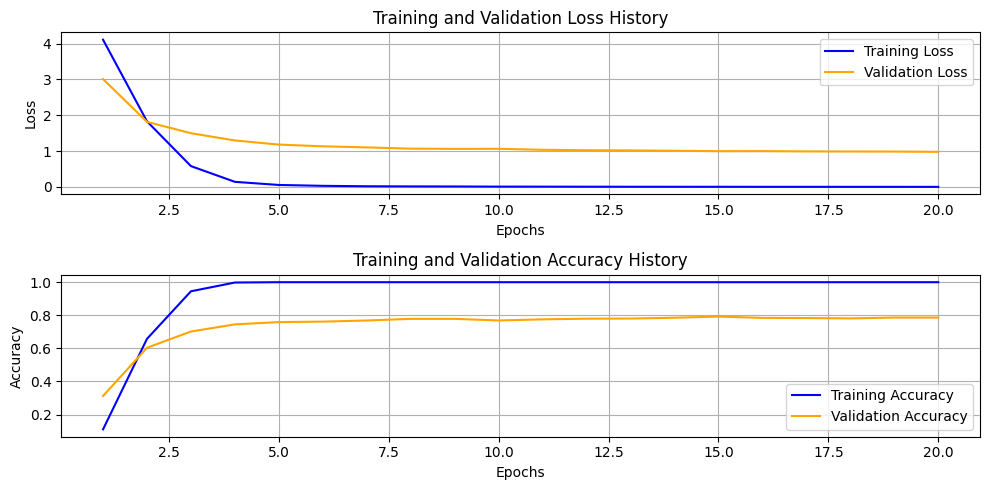

In [29]:
# cell for plotting training and validation metrics
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss_history, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_history, 'orange', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(epochs, train_acc_history, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc_history, 'orange', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy History')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [32]:
# evaluate best saved model on test dataset
model.load_state_dict(torch.load('Best_VGG16_MSResNet.pth'))
test_acc = test_model(model, test_loader, device)
print(f"Test Accuracy: {test_acc:.4f}")

<ipython-input-32-11ffeaf553cb>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Best_VGG16_MSResNet'))


Test Accuracy: 0.7779


## Analysis of Results
### The training and validation loss graphs show a steady decrease in loss over the epochs, with both curves stabilizing, indicating successful learning. The accuracy graphs show a sharp increase in training accuracy, while validation accuracy improves more gradually, with a gap that slightly narrows towards the end. The model achieved a test accuracy of 77.79%, suggesting reasonable performance on the test set.